In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.utils import shuffle # library to shuffle the dataframes
import seaborn as sns # library to plot and visualize data
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix

In [69]:
# Defining the datatype of each column for reading the CSV file
dataTypes = {
    "UniqueID": np.int64,
    "disbursed_amount": np.float64,
    "asset_cost": np.float64,
    "ltv": np.float64,
    "branch_id": np.object,
    "supplier_id": np.object,
    "manufacturer_id": np.object,
    "Current_pincode_ID": np.object,
    "Date.of.Birth": np.object,
    "Employment.Type": np.object,
    "DisbursalDate": np.object,
    "State_ID": np.object,
    "Employee_code_ID": np.object,
    "MobileNo_Avl_Flag": np.bool_,
    "Aadhar_flag": np.bool_,
    "PAN_flag": np.bool_,
    "VoterID_flag": np.bool_,
    "Driving_flag": np.bool_,
    "Passport_flag": np.bool_,
    "PERFORM_CNS.SCORE": np.int64,
    "PERFORM_CNS.SCORE.DESCRIPTION": np.object,
    "PRI.NO.OF.ACCTS": np.int64,
    "PRI.ACTIVE.ACCTS": np.int64,
    "PRI.OVERDUE.ACCTS": np.int64,
    "PRI.CURRENT.BALANCE": np.float64,
    "PRI.SANCTIONED.AMOUNT": np.float64,
    "PRI.DISBURSED.AMOUNT": np.float64,
    "SEC.NO.OF.ACCTS": np.int64,
    "SEC.ACTIVE.ACCTS": np.int64,
    "SEC.OVERDUE.ACCTS": np.int64,
    "SEC.CURRENT.BALANCE": np.float64,
    "SEC.SANCTIONED.AMOUNT": np.float64,
    "SEC.DISBURSED.AMOUNT": np.float64,
    "PRIMARY.INSTAL.AMT": np.float64,
    "SEC.INSTAL.AMT": np.float64,
    "NEW.ACCTS.IN.LAST.SIX.MONTHS": np.int64,
    "DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS": np.int64,
    "AVERAGE.ACCT.AGE": np.object,
    "CREDIT.HISTORY.LENGTH": np.object,
    "NO.OF_INQUIRIES": np.int64,
    "loan_default": np.object
}

columnsToDrop = {
    "supplier_id",
    "UniqueID",
    "Date.of.Birth",
    "DisbursalDate",
    "PERFORM_CNS.SCORE",
    "PERFORM_CNS.SCORE.DESCRIPTION",
    'Employment.Type',
    'branch_id',
    'manufacturer_id',
    'Current_pincode_ID',
    'State_ID',
    'Employee_code_ID',
    'Passport_flag',
    'SEC.OVERDUE.ACCTS',
    'SEC.ACTIVE.ACCTS',
    'SEC.INSTAL.AMT',
    "SEC.INSTAL.AMT",
    "SEC.CURRENT.BALANCE",
    'SEC.SANCTIONED.AMOUNT',
    'SEC.DISBURSED.AMOUNT',
    'SEC.NO.OF.ACCTS'
}

In [65]:
# Input data files are available in the "../data/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
trainRaw = pd.read_csv("data/train.csv", dtype=dataTypes)

# Shuffle the dataframes
trainRaw = shuffle(trainRaw)

Shape of Train : (233154, 41)

Load default distribution :


0    182543
1     50611
Name: loan_default, dtype: int64

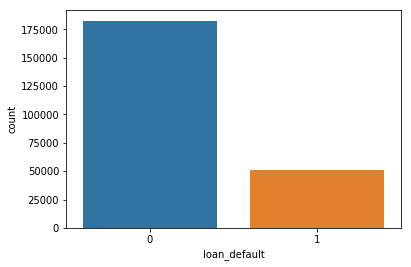

In [66]:
print("Shape of Train :", trainRaw.shape)
print("\nLoad default distribution :")
sns.countplot(x=trainRaw.loan_default)
trainRaw.loan_default.value_counts()

In [67]:
def parseDuration(x):
    x_yrs = x.split()[0]
    x_mon = x.split()[1]
    n_years = x_yrs[:(len(x_yrs)-3)]
    n_mon = x_mon[:(len(x_mon)-3)]
    return int(n_years) * 12 + int(n_mon)

def parseDate(v):
    if v.split("-")[-1]=='00' or v.split("-")[-1]=='18':
        return "-".join(v.split("-")[:-1])+'-20'+"".join(v.split("-")[-1])
    else:
        return "-".join(v.split("-")[:-1])+'-19'+"".join(v.split("-")[-1])
    
def getScoreGrade(desc):
    grade = desc.split("-")
    if len(grade) != 1:
        return grade[0]
    else:
        return 'Z'

#Pre-Process the data
def preProcessData(raw):
    data = raw.copy()
    data['Sanctioned'] = (data['asset_cost'] * (data['ltv'] / 100)).astype(np.float64)
    
    data['Date.of.Birth'] = pd.to_datetime(data['Date.of.Birth'].apply(parseDate), format='%d-%m-%Y', errors='coerce')
    data['DisbursalDate'] = pd.to_datetime(data['DisbursalDate'].apply(parseDate), format='%d-%m-%Y')
    data['AgeAtDisbursal'] = (data['DisbursalDate'] - data['Date.of.Birth']).astype('<m8[Y]')
    
    data['Employment.Type'].fillna('Other', inplace=True)
    
    data['AVERAGE.ACCT.AGE'] = data['AVERAGE.ACCT.AGE'].apply(parseDuration)
    data['CREDIT.HISTORY.LENGTH'] = data['CREDIT.HISTORY.LENGTH'].apply(parseDuration)
    data['TOTAL.ACTIVE.ACCTS'] = (data['PRI.ACTIVE.ACCTS'] + data['SEC.ACTIVE.ACCTS']).astype(np.int64)
    data['TOTAL.CURRENT.BALANCE'] = (data['PRI.CURRENT.BALANCE'] + data['SEC.CURRENT.BALANCE']).astype(np.float64)
    data['TOTAL.DISBURSED.AMOUNT'] = (data['PRI.DISBURSED.AMOUNT'] + data['SEC.DISBURSED.AMOUNT']).astype(np.int64)
    data['TOTAL.NO.OF.ACCTS'] = (data['PRI.NO.OF.ACCTS'] + data['SEC.NO.OF.ACCTS']).astype(np.int64)
    data['TOTAL.OVERDUE.ACCTS'] = (data['PRI.OVERDUE.ACCTS'] + data['SEC.OVERDUE.ACCTS']).astype(np.int64)
    data['TOTAL.CLEAN.ACCTS'] = (data['TOTAL.NO.OF.ACCTS'] - data['TOTAL.OVERDUE.ACCTS']).astype(np.int64)
    data['NO.OF.ACC.BF.SIX.MONTH'] = (data['TOTAL.NO.OF.ACCTS'] - data['NEW.ACCTS.IN.LAST.SIX.MONTHS']).astype(np.int64)
    data['OVERDUE.ACC.BF.SIX.MONTHS'] = (data['TOTAL.OVERDUE.ACCTS'] - data['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS']).astype(np.int64)
    data['TOTAL.DEACTIVE.ACCTS'] = (data['TOTAL.NO.OF.ACCTS'] - data['TOTAL.ACTIVE.ACCTS']).astype(np.int64)
    data['TOTAL.INSTL.AMOUNT'] = (data['PRIMARY.INSTAL.AMT'] + data['SEC.INSTAL.AMT']).astype(np.float64)
    data['TOTAL.CLEARED.ACCTS']= (data['TOTAL.NO.OF.ACCTS'] - data['TOTAL.ACTIVE.ACCTS'] + data['TOTAL.OVERDUE.ACCTS']).astype(np.int64)
        
    for col in data.columns:
        if data[col].nunique() == 1:
            data.drop(col, axis=1, inplace=True)
            print(f'{col} dropped as it has only one unique value')

    data['PERFORM_CNS.SCORE.DESCRIPTION'].replace({
        'A-Very Low Risk':'Very LRisk',
        'C-Very Low Risk':'Very LRisk',
        'B-Very Low Risk':'Very LRisk',
        'D-Very Low Risk':'Very LRisk',
        'E-Low Risk':'Low Risk',
        'F-Low Risk':'Low Risk',
        'G-Low Risk':'Low Risk',
        'H-Medium Risk':'Medium Risk',
        'I-Medium Risk':'Medium Risk',
        'J-High Risk':'High Risk',
        'K-High Risk':'High Risk',
        'L-Very High Risk':'Very HRisk',
        'M-Very High Risk':'Very HRisk'}, inplace=True)
    
    data['Not_Scored'] = np.where(data['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Not Scored'), 1, 0)
    data['No_History'] = np.where(data['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('No Bureau'), 1, 0)
    data['Very_Low_Risk'] = np.where(data['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Very LRisk'), 1, 0)
    data['Low_Risk'] = np.where(data['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Low Risk'), 1, 0)
    data['Medium_Risk'] = np.where(data['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Medium Risk'), 1, 0)
    data['Very_Low_Risk'] = np.where(data['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('High Risk'), 1, 0)
    data['Very_High_Risk'] = np.where(data['PERFORM_CNS.SCORE.DESCRIPTION'].str.contains('Very HRisk'), 1, 0)
    
    X = pd.get_dummies(data["Employment.Type"], prefix="Employment.Type", drop_first=False, dtype=np.bool_)
    data = pd.concat([data, X], axis=1)

    index = 0
    prev = 0
    for i in range(100, 901, 100):
        data.loc[(data['PERFORM_CNS.SCORE'] < i) & (data['PERFORM_CNS.SCORE'] >= prev), 'PERFORM_CNS.SCORE'] = index
        index = index + 1
        prev = i
        
    X = pd.get_dummies(data["PERFORM_CNS.SCORE"], prefix="PERFORM_CNS.SCORE", drop_first=False, dtype=np.bool_)
    data = pd.concat([data, X], axis=1)
    
    data = data.drop(columnsToDrop, axis=1)
    
    return data

In [70]:
train = preProcessData(trainRaw)

MobileNo_Avl_Flag dropped as it has only one unique value


In [71]:
X = train.drop('loan_default', 1)
y = train['loan_default']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

In [73]:
rf = RandomForestClassifier() 
## Fit the model on your training data.
rf.fit(X_train, y_train) 
## And score it on your testing data.

y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

#Applying 10-fold cross validation
accuracies = cross_val_score(estimator=rf, X=X_train, y=y_train, cv=10)
print("accuracy (10-fold): ", np.mean(accuracies))

c:\applications\python\python37\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[[52309  2464]
 [14078  1096]]
accuracy (10-fold):  0.7633986283610315


In [74]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [75]:
feature_importances

,importance
ltv,0.144527
Sanctioned,0.140228
asset_cost,0.139569
disbursed_amount,0.128485
AgeAtDisbursal,0.097561
CREDIT.HISTORY.LENGTH,0.025333
AVERAGE.ACCT.AGE,0.024006
PRI.CURRENT.BALANCE,0.022323
TOTAL.CURRENT.BALANCE,0.022246
TOTAL.INSTL.AMOUNT,0.021608
